In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import tensorflow as tf
from collections import Counter

%matplotlib inline

In [11]:
# uncomment the group you want to train on
race = "hispanic"
#race = "white"
#race = "mixed"

In [26]:
X = np.load('../Data/' + race + '/X.npy')
Y2 = np.load('../Data/' + race + '/Y2.npy')

In [13]:
size_hispanic = 37575

In [14]:
X.shape

(37575, 301)

In [15]:
# shuffle
np.random.seed(42)
idx = np.random.permutation(len(X))
X = X[idx]
Y = Y2[idx]

#if race != 'hispanic':
#   X = X[:size_hispanic]
#    Y = Y[:size_hispanic]

TEST_SET_SIZE = int(0.1*len(Y))

X_train, X_test = X[:-TEST_SET_SIZE], X[-TEST_SET_SIZE:]
Y_train, Y_test = Y[:-TEST_SET_SIZE].astype(int), Y[-TEST_SET_SIZE:].astype(int)

In [16]:
X.shape

(37575, 301)

In [17]:
# Features Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
std_scaler = StandardScaler()
X_train[:,-4:] = std_scaler.fit_transform(X_train[:,-4:])
X_test[:,-4:] = std_scaler.transform(X_test[:,-4:])

mm_scaler = MinMaxScaler(feature_range=(0,1))
X_train[:,:-4] = mm_scaler.fit_transform(X_train[:,:-4])
X_test[:,:-4] = mm_scaler.transform(X_test[:,:-4])

/home/samuel/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/samuel/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [18]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix

def results(classifier,threshold=0.5, X_test=X_test, Y_test=Y_test):
    Y_pred_test = classifier.predict(X_test)
    Y_pred_test = (Y_pred_test>=threshold).astype(int)
    #Y_pred_test = np.rint(Y_pred_test)
    print("Test accuracy score: " + str(accuracy_score(Y_test.astype(int), Y_pred_test)))
    print("ROC: " + str(roc_auc_score(Y_test, classifier.predict(X_test))))
    #print("ROC: " + str(roc_auc_score(Y_test, Y_pred_test)))
    matrix = confusion_matrix(Y_test.astype(int), Y_pred_test)
    tn, fp, fn, tp = matrix.ravel()
    ppv = tp/(tp+fp)
    npv = tn/(tn+fn)
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    g_mean = np.sqrt(sensitivity*specificity)
    print("PPV: " + str(ppv))
    print("NPV: " + str(npv))
    print("Sensitivity: " + str(sensitivity))
    print("Specificity: " + str(specificity))
    print("G-Mean: " + str(g_mean))
    print("Confusion matrix:\n" + str(matrix))
    
    return str(roc_auc_score(Y_test, classifier.predict(X_test)))[:6], str(sensitivity)[:6], str(specificity)[:6], str(g_mean)[:6]

## Undersample

In [89]:
from imblearn.under_sampling import RandomUnderSampler
us = RandomUnderSampler(ratio=1.0)
X_train_res, Y_train_res = us.fit_sample(X_train, Y_train)

/home/samuel/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [12]:
Counter(Y_train)

Counter({0: 6095, 1: 27723})

In [24]:
from tensorflow import keras
from keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras import regularizers
from keras.layers import Conv1D, MaxPooling1D, Flatten

## ConvNet

In [ ]:
var_layers = 2
#var_act_maps = 2
#var_kernel_size = 10
#var_dense_layer = 100


for var_act_maps in [2,4,8,16]:
    for var_kernel_size in [10,20,50,100,150]:
        for var_dense_layer in [25,50,100,200,300]:
            model = Sequential()
            model.add(Conv1D(var_act_maps, kernel_size=var_kernel_size, strides=1,
                             activation=None, padding="same",
                             input_shape=(X_train.shape[1],1), name='layer1'))
            model.add(LeakyReLU(0.02))
            #model.add(MaxPooling1D(pool_size=2, strides=None))
            #model.add(Dropout(0.2))
            '''
            model.add(Conv1D(var_act_maps*2, kernel_size=var_kernel_size, strides=1,
                 activation='relu', padding="same",
                 input_shape=(X_train.shape[1],1), name='layer2'))
            '''
            '''
            
            model.add(Conv1D(var_act_maps*2, kernel_size=var_kernel_size, strides=1,
             activation='relu', padding="same",
             input_shape=(X_train.shape[1],1), name='layer3'))
            '''
            model.add(Flatten())
            model.add(Dense(var_dense_layer, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))


            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            model.fit(X_train.reshape((-1, X_train.shape[1],1)), Y_train, epochs=10, batch_size=200,)
            scores = model.evaluate(X_test.reshape(-1,X_test.shape[1],1), Y_test)
            print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
            o1, o2, o3, o4 = results(model, X_test=X_test.reshape(-1,X_test.shape[1],1))
            fd = open('leaky_relu.csv','a')
            output_arr = [var_layers, var_act_maps, var_kernel_size, var_dense_layer, o1, o2, o3, o4]
            fd.write(','.join(map(str,output_arr))+'\n')
            fd.close()

Epoch 1/10
33818/33818 [==============================] - 21s 634us/step - loss: 0.3766 - acc: 0.8353
Epoch 2/10
33818/33818 [==============================] - 3s 86us/step - loss: 0.3369 - acc: 0.8526
Epoch 3/10
33818/33818 [==============================] - 3s 87us/step - loss: 0.3316 - acc: 0.8548
Epoch 4/10
33818/33818 [==============================] - 3s 84us/step - loss: 0.3290 - acc: 0.8567
Epoch 5/10
33818/33818 [==============================] - 3s 85us/step - loss: 0.3282 - acc: 0.8565
Epoch 6/10
33818/33818 [==============================] - 3s 85us/step - loss: 0.3267 - acc: 0.8574
Epoch 7/10
33818/33818 [==============================] - 3s 85us/step - loss: 0.3250 - acc: 0.8580
Epoch 8/10
33818/33818 [==============================] - 3s 87us/step - loss: 0.3232 - acc: 0.8585
Epoch 9/10
33818/33818 [==============================] - 3s 87us/step - loss: 0.3221 - acc: 0.8575
Epoch 10/10
3757/3757 [==============================] - 10s 3ms/step

acc: 85.41%
Test accuracy s

33818/33818 [==============================] - 5s 137us/step - loss: 0.3204 - acc: 0.8592
Epoch 6/10
33818/33818 [==============================] - 5s 137us/step - loss: 0.3190 - acc: 0.8601
Epoch 7/10
33818/33818 [==============================] - 5s 136us/step - loss: 0.3172 - acc: 0.8617
Epoch 8/10
33818/33818 [==============================] - 5s 137us/step - loss: 0.3147 - acc: 0.8634
Epoch 9/10
33818/33818 [==============================] - 5s 137us/step - loss: 0.3111 - acc: 0.8639
Epoch 10/10
3757/3757 [==============================] - 10s 3ms/step

acc: 85.28%
Test accuracy score: 0.8528080915624168
ROC: 0.8689783748902247
PPV: 0.896530165676774
NPV: 0.6021505376344086
Sensitivity: 0.9281553398058252
Specificity: 0.5037481259370314
G-Mean: 0.6837810417126473
Confusion matrix:
[[ 336  331]
 [ 222 2868]]
Epoch 1/10
33818/33818 [==============================] - 24s 707us/step - loss: 0.3526 - acc: 0.8463
Epoch 2/10
33818/33818 [==============================] - 5s 141us/step - 

33818/33818 [==============================] - 9s 267us/step - loss: 0.3085 - acc: 0.8668
Epoch 10/10
3757/3757 [==============================] - 11s 3ms/step

acc: 85.07%
Test accuracy score: 0.8506787330316742
ROC: 0.8611225940427845
PPV: 0.8643042350907519
NPV: 0.6853146853146853
Sensitivity: 0.970873786407767
Specificity: 0.2938530734632684
G-Mean: 0.534129428210844
Confusion matrix:
[[ 196  471]
 [  90 3000]]
Epoch 1/10
33818/33818 [==============================] - 23s 685us/step - loss: 0.3549 - acc: 0.8451
Epoch 2/10
33818/33818 [==============================] - 3s 92us/step - loss: 0.3303 - acc: 0.8542
Epoch 3/10
33818/33818 [==============================] - 3s 93us/step - loss: 0.3263 - acc: 0.8572
Epoch 4/10
33818/33818 [==============================] - 3s 93us/step - loss: 0.3240 - acc: 0.8573
Epoch 5/10
33818/33818 [==============================] - 3s 93us/step - loss: 0.3216 - acc: 0.8582
Epoch 6/10
33818/33818 [==============================] - 3s 92us/step - loss: 

Epoch 1/10
33818/33818 [==============================] - 25s 751us/step - loss: 0.3517 - acc: 0.8454
Epoch 2/10
33818/33818 [==============================] - 5s 145us/step - loss: 0.3293 - acc: 0.8556
Epoch 3/10
33818/33818 [==============================] - 5s 145us/step - loss: 0.3255 - acc: 0.8569
Epoch 4/10
33818/33818 [==============================] - 5s 145us/step - loss: 0.3228 - acc: 0.8576
Epoch 5/10
33818/33818 [==============================] - 5s 145us/step - loss: 0.3205 - acc: 0.8592
Epoch 6/10
33818/33818 [==============================] - 5s 143us/step - loss: 0.3180 - acc: 0.8603
Epoch 7/10
33818/33818 [==============================] - 5s 145us/step - loss: 0.3160 - acc: 0.8623
Epoch 8/10
33818/33818 [==============================] - 5s 145us/step - loss: 0.3145 - acc: 0.8635
Epoch 9/10
33818/33818 [==============================] - 5s 144us/step - loss: 0.3125 - acc: 0.8625
Epoch 10/10
3757/3757 [==============================] - 11s 3ms/step

acc: 85.31%
Test ac

33818/33818 [==============================] - 7s 194us/step - loss: 0.3249 - acc: 0.8568
Epoch 4/10
33818/33818 [==============================] - 7s 195us/step - loss: 0.3225 - acc: 0.8593
Epoch 5/10
33818/33818 [==============================] - 7s 193us/step - loss: 0.3199 - acc: 0.8592
Epoch 6/10
33818/33818 [==============================] - 7s 194us/step - loss: 0.3172 - acc: 0.8603
Epoch 7/10
33818/33818 [==============================] - 7s 194us/step - loss: 0.3146 - acc: 0.8623
Epoch 8/10
33818/33818 [==============================] - 7s 194us/step - loss: 0.3118 - acc: 0.8650
Epoch 9/10
33818/33818 [==============================] - 7s 193us/step - loss: 0.3086 - acc: 0.8653
Epoch 10/10
3757/3757 [==============================] - 11s 3ms/step

acc: 85.09%
Test accuracy score: 0.850944902848017
ROC: 0.8690089421308763
PPV: 0.8852009744214373
NPV: 0.6131078224101479
Sensitivity: 0.9407766990291262
Specificity: 0.43478260869565216
G-Mean: 0.6395571494432439
Confusion matrix:


33818/33818 [==============================] - 10s 297us/step - loss: 0.3196 - acc: 0.8600
Epoch 6/10
33818/33818 [==============================] - 10s 297us/step - loss: 0.3171 - acc: 0.8615
Epoch 7/10
33818/33818 [==============================] - 10s 297us/step - loss: 0.3150 - acc: 0.8629
Epoch 8/10
33818/33818 [==============================] - 10s 297us/step - loss: 0.3118 - acc: 0.8649
Epoch 9/10
33818/33818 [==============================] - 10s 298us/step - loss: 0.3081 - acc: 0.8654
Epoch 10/10
3757/3757 [==============================] - 12s 3ms/step

acc: 85.65%
Test accuracy score: 0.8565344689912164
ROC: 0.8695962698262518
PPV: 0.8906584992343032
NPV: 0.6300813008130082
Sensitivity: 0.9411003236245955
Specificity: 0.46476761619190404
G-Mean: 0.6613569036522056
Confusion matrix:
[[ 310  357]
 [ 182 2908]]
Epoch 1/10
33818/33818 [==============================] - 25s 731us/step - loss: 0.3560 - acc: 0.8413
Epoch 2/10
33818/33818 [==============================] - 3s 99us/s

33818/33818 [==============================] - 5s 148us/step - loss: 0.3144 - acc: 0.8631
Epoch 10/10
3757/3757 [==============================] - 12s 3ms/step

acc: 85.23%
Test accuracy score: 0.8522757519297312
ROC: 0.8671601092657554
PPV: 0.9012345679012346
NPV: 0.5936454849498328
Sensitivity: 0.9213592233009709
Specificity: 0.5322338830584707
G-Mean: 0.7002703742906824
Confusion matrix:
[[ 355  312]
 [ 243 2847]]
Epoch 1/10
33818/33818 [==============================] - 27s 811us/step - loss: 0.3513 - acc: 0.8451
Epoch 2/10
33818/33818 [==============================] - 5s 154us/step - loss: 0.3298 - acc: 0.8546
Epoch 3/10
33818/33818 [==============================] - 5s 154us/step - loss: 0.3259 - acc: 0.8565
Epoch 4/10
33818/33818 [==============================] - 5s 154us/step - loss: 0.3237 - acc: 0.8579
Epoch 5/10
33818/33818 [==============================] - 5s 154us/step - loss: 0.3218 - acc: 0.8587
Epoch 6/10
33818/33818 [==============================] - 5s 153us/step -

Epoch 1/10
33818/33818 [==============================] - 34s 1ms/step - loss: 0.3459 - acc: 0.8447
Epoch 2/10
33818/33818 [==============================] - 11s 323us/step - loss: 0.3294 - acc: 0.8538
Epoch 3/10
33818/33818 [==============================] - 11s 323us/step - loss: 0.3261 - acc: 0.8557
Epoch 4/10
33818/33818 [==============================] - 11s 327us/step - loss: 0.3232 - acc: 0.8566
Epoch 5/10
33818/33818 [==============================] - 11s 325us/step - loss: 0.3203 - acc: 0.8592
Epoch 6/10
33818/33818 [==============================] - 11s 324us/step - loss: 0.3205 - acc: 0.8603
Epoch 7/10
33818/33818 [==============================] - 11s 323us/step - loss: 0.3174 - acc: 0.8593
Epoch 8/10
33818/33818 [==============================] - 11s 328us/step - loss: 0.3154 - acc: 0.8625
Epoch 9/10
33818/33818 [==============================] - 11s 326us/step - loss: 0.3109 - acc: 0.8645
Epoch 10/10
3757/3757 [==============================] - 12s 3ms/step

acc: 84.75%
T

Epoch 3/10
33818/33818 [==============================] - 4s 132us/step - loss: 0.3332 - acc: 0.8545
Epoch 4/10
33818/33818 [==============================] - 4s 132us/step - loss: 0.3289 - acc: 0.8547
Epoch 5/10
33818/33818 [==============================] - 5s 134us/step - loss: 0.3278 - acc: 0.8562
Epoch 6/10
33818/33818 [==============================] - 5s 134us/step - loss: 0.3266 - acc: 0.8570
Epoch 7/10
33818/33818 [==============================] - 5s 134us/step - loss: 0.3247 - acc: 0.8566
Epoch 8/10
33818/33818 [==============================] - 4s 132us/step - loss: 0.3241 - acc: 0.8584
Epoch 9/10
33818/33818 [==============================] - 5s 137us/step - loss: 0.3232 - acc: 0.8574
Epoch 10/10
3757/3757 [==============================] - 13s 3ms/step

acc: 85.52%
Test accuracy score: 0.8552036199095022
ROC: 0.8697665730241675
PPV: 0.8914514145141451
NPV: 0.6217821782178218
Sensitivity: 0.9381877022653722
Specificity: 0.4707646176911544
G-Mean: 0.6645792465759824
Confusi

33818/33818 [==============================] - 6s 173us/step - loss: 0.3204 - acc: 0.8592
Epoch 6/10
33818/33818 [==============================] - 6s 173us/step - loss: 0.3188 - acc: 0.8607
Epoch 7/10
33818/33818 [==============================] - 6s 174us/step - loss: 0.3172 - acc: 0.8616
Epoch 8/10
33818/33818 [==============================] - 6s 174us/step - loss: 0.3158 - acc: 0.8621
Epoch 9/10
33818/33818 [==============================] - 6s 177us/step - loss: 0.3140 - acc: 0.8625
Epoch 10/10
3757/3757 [==============================] - 13s 4ms/step

acc: 85.07%
Test accuracy score: 0.8506787330316742
ROC: 0.8684999733143137
PPV: 0.8823707287571817
NPV: 0.6177777777777778
Sensitivity: 0.944336569579288
Specificity: 0.41679160419790107
G-Mean: 0.6273687541930139
Confusion matrix:
[[ 278  389]
 [ 172 2918]]
Epoch 1/10
33818/33818 [==============================] - 32s 945us/step - loss: 0.3496 - acc: 0.8485
Epoch 2/10
33818/33818 [==============================] - 7s 195us/step -

/home/samuel/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108650). Check your callbacks.
  % delta_t_median)


3757/3757 [==============================] - 13s 3ms/step

acc: 85.57%
Test accuracy score: 0.855735959542188
ROC: 0.871725302397345
PPV: 0.8986232790988736
NPV: 0.6114081996434938
Sensitivity: 0.9294498381877022
Specificity: 0.5142428785607196
G-Mean: 0.6913486531898642
Confusion matrix:
[[ 343  324]
 [ 218 2872]]
Epoch 1/10
33818/33818 [==============================] - 36s 1ms/step - loss: 0.3668 - acc: 0.8430
Epoch 2/10
33818/33818 [==============================] - 11s 322us/step - loss: 0.3284 - acc: 0.8557
Epoch 3/10
33818/33818 [==============================] - 11s 320us/step - loss: 0.3287 - acc: 0.8552
Epoch 4/10
33818/33818 [==============================] - 11s 321us/step - loss: 0.3253 - acc: 0.8583
Epoch 5/10
33818/33818 [==============================] - 11s 322us/step - loss: 0.3225 - acc: 0.8588
Epoch 6/10
33818/33818 [==============================] - 11s 323us/step - loss: 0.3199 - acc: 0.8598
Epoch 7/10
33818/33818 [==============================] - 11s 321us/step 

In [13]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train.reshape((-1, X_train.shape[1],1)), Y_train, epochs=10, batch_size=200,)

scores = model.evaluate(X_test.reshape(-1,X_test.shape[1],1), Y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/10
33818/33818 [==============================] - 2s 47us/step - loss: 0.3781 - acc: 0.8409
Epoch 2/10
33818/33818 [==============================] - 1s 42us/step - loss: 0.3295 - acc: 0.8550
Epoch 3/10
33818/33818 [==============================] - 1s 42us/step - loss: 0.3255 - acc: 0.8576
Epoch 4/10
33818/33818 [==============================] - 1s 41us/step - loss: 0.3228 - acc: 0.8582
Epoch 5/10
33818/33818 [==============================] - 1s 38us/step - loss: 0.3208 - acc: 0.8593
Epoch 6/10
33818/33818 [==============================] - 1s 43us/step - loss: 0.3186 - acc: 0.8614
Epoch 7/10
33818/33818 [==============================] - 1s 41us/step - loss: 0.3171 - acc: 0.8614
Epoch 8/10
33818/33818 [==============================] - 1s 42us/step - loss: 0.3159 - acc: 0.8629
Epoch 9/10
33818/33818 [==============================] - 1s 42us/step - loss: 0.3133 - acc: 0.8634
Epoch 10/10
3757/3757 [==============================] - 0s 80us/step

acc: 85.23%


In [14]:
o1, o2, o3, o4 = results(model, X_test=X_test.reshape(-1,X_test.shape[1],1))
fd = open('conv_results.csv','a')
output_arr = [var_layers, var_act_maps, var_kernel_size, var_dense_layer, o1, o2, o3, o4]
fd.write(','.join(map(str,output_arr))+'\n')
fd.close()

Test accuracy score: 0.8522757519297312
ROC: 0.8667884504349768
PPV: 0.8851412944393802
NPV: 0.6201716738197425
Sensitivity: 0.9427184466019417
Specificity: 0.4332833583208396
G-Mean: 0.6391120515955667
Confusion matrix:
[[ 289  378]
 [ 177 2913]]


In [104]:
','.join(map(str,output_arr))

'1,2,10,25,0.8653755646448621,0.9313915857605178,0.49325337331334335,0.6777994110000684'

In [43]:
from keras import backend as K
get_1st_layer_output = K.function([model.layers[0].input],
                                  [model.layers[1].output])
#layer_output = get_1st_layer_output([X])

In [47]:
layer_output = get_1st_layer_output([X_test[0].reshape(-1,301,1)])


In [62]:
l1 = model.get_layer("layer1")
l1.get_weights()[0].ravel()

array([-0.39937037, -0.25302196, -0.33779934, -0.37349048,  0.6447491 ,
        0.5206269 ,  0.27678737,  0.48182878,  0.12258197, -0.25269464,
        0.02413214, -0.06378173,  0.22032526, -0.05318109, -0.21164675,
        0.4822819 , -0.28148416, -0.3359999 ,  0.57592595, -0.11844412],
      dtype=float32)

In [52]:
layer_output[0]

array([[[0.29736763, 1.2431245 ],
        [0.        , 2.2837203 ],
        [0.13863301, 0.        ],
        [1.5686494 , 0.7052522 ],
        [0.39594883, 0.1298283 ],
        [1.253913  , 0.11430365],
        [0.24566686, 0.12651321],
        [0.387007  , 0.88803077],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.51385486, 1.1676648 ],
        [0.        , 0.        ],
        [0.87386173, 0.        ],
        [0.24566686, 0.12651321],
        [0.387007  , 0.88803077],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.006

## Train

In [44]:
from tensorflow import keras
from keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras import regularizers

model = Sequential()

model.add(Dense(400, kernel_initializer='he_normal', input_dim=X.shape[1], name='layer1'))
model.add(LeakyReLU(alpha=0.1))
#model.add(BatchNormalization())
model.add(Dropout(0.1))


model.add(Dense(400, kernel_initializer='he_normal',name='layer2'))
model.add(LeakyReLU(alpha=0.1))
#model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(400, kernel_initializer='he_normal',name='layer3'))
model.add(LeakyReLU(alpha=0.1))
#model.add(BatchNormalization())
model.add(Dropout(0.1))


model.add(Dense(1, activation='sigmoid'))

In [45]:
from keras.optimizers import Adam

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=10, batch_size=250)
scores = model.evaluate(X_test, Y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/10
33818/33818 [==============================] - 2s 70us/step - loss: 0.4937 - acc: 0.8210
Epoch 2/10
33818/33818 [==============================] - 2s 53us/step - loss: 0.3545 - acc: 0.8441
Epoch 3/10
33818/33818 [==============================] - 2s 53us/step - loss: 0.3455 - acc: 0.8487
Epoch 4/10
33818/33818 [==============================] - 2s 53us/step - loss: 0.3423 - acc: 0.8514
Epoch 5/10
33818/33818 [==============================] - 2s 53us/step - loss: 0.3392 - acc: 0.8502
Epoch 6/10
33818/33818 [==============================] - 2s 54us/step - loss: 0.3367 - acc: 0.8536
Epoch 7/10
33818/33818 [==============================] - 2s 54us/step - loss: 0.3351 - acc: 0.8537
Epoch 8/10
33818/33818 [==============================] - 2s 54us/step - loss: 0.3335 - acc: 0.8540
Epoch 9/10
33818/33818 [==============================] - 2s 54us/step - loss: 0.3328 - acc: 0.8553
Epoch 10/10
3757/3757 [==============================] - 0s 106us/step

acc: 81.79%


In [46]:
results(model)

Test accuracy score: 0.8179398456215066
ROC: 0.8592737611776635
PPV: 0.9299499642601858
NPV: 0.49113660062565173
Sensitivity: 0.8420711974110032
Specificity: 0.7061469265367316
G-Mean: 0.7711199569307523
Confusion matrix:
[[ 471  196]
 [ 488 2602]]


(array([  189.,   703.,  1011.,  1141.,  1029.,  1127.,  1349.,  1914.,
         3758., 21597.]),
 array([0.14018634, 0.22614742, 0.3121085 , 0.39806959, 0.48403067,
        0.56999175, 0.65595284, 0.74191392, 0.827875  , 0.91383608,
        0.99979717]),
 <a list of 10 Patch objects>)

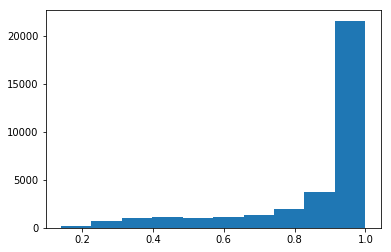

In [174]:
plt.hist(model.predict(X_train))

In [159]:
Y_pred1 = (model.predict(X_test)>0.5).astype(int)
print(accuracy_score(Y_test, Y_pred1))
confusion_matrix(Y_test, Y_pred1)

0.8522757519297312


array([[ 384,  283],
       [ 272, 2818]])

In [285]:
l1 = model.get_layer("layer1")
l1.get_weights()[0].ravel()

array([-0.02789835,  0.02168945,  0.01079839, ..., -0.02229493,
       -0.01450237, -0.04505375], dtype=float32)

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.0000e+00, 4.0000e+01, 3.3980e+03, 1.8989e+04, 3.5773e+04,
        3.7403e+04, 2.0493e+04, 4.2600e+03, 3.7000e+01, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([-1.        , -0.93333333, -0.86666667, -0.8       , -0.73333333,
        -0.66666667, -0.6       , -0.53333333, -0.46666667, -0.4       ,
        -0.33333333, -0.26666667, -0.2       , -0.13333333, -0.06666667,
         0.        ,  0.06666667,  0.13333333,  0.2       ,  0.26666667,
         0.33333333,  0.4       ,  0.46666667,  0.53333333,  0.6       ,
         0.66666667,  0.73333333,  0.8       ,  0.86666667,  0.93333333,
         1.        ]),
 <a list of 30 Patch objects>)

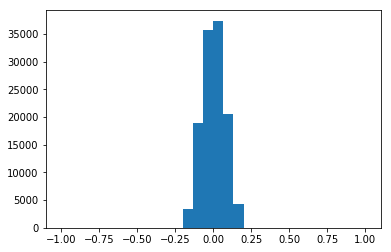

In [99]:
l1 = model.get_layer("layer1")
plt.hist(l1.get_weights()[0].ravel(), bins=30, range=(-1,1))